# Second Report: Financial Market Volatility

By: Abigail Alpert and Gabi Wurgaft

# Executive Summary
We will be predicting the short term volatility of three stocks. Through these predictions we will make recommendations to their investors and the general public whether to buy, sell, or short this stock. Our predictions will also assess whether the stock is generally stable or very volatile, which will impact decisions of whether to invest in these stocks in the short term.\
Our financial market volatility forecaster provides business value primarily to individuals. Our goal is to create a model that can inform people on whether they should or should not invest in a particular stock for short-term gain. By modelling stock volatility, investors will be more informed about the likelihood of how a specific stock will gain and lose value over a short-term timeframe. This information will (hopefully) help minimize risk.\
The data asset we are using is the AlphaVantage API. It provides 20+ years of historical global equity data in the form of intraday, daily, weekly, and monthly stock prices. We are using 1-minute intraday stock price data for Apple, Brookfield Renewable Partners, and Eli Lilly. We use this data to calculate the volatility for each day and predict future volatility.

In [50]:
# Load Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import patchworklib as pw
import datetime

# Data Preprocessing

We pulled five years of 1-minute returns for the Apple, Brookfield Renewable Partners, and Eli Lilly stocks from the AlphaVantage API
The data pulled from the API was fairly clean to begin with so for the initial preprocessing we simply renamed columns and handled timestamps.\
We looked at the summary statistics to better understand the data, as well as plotted the open, close, high, and low prices of each stock to understand any trends. Below are those visualizations and summary statistics:

In [3]:
# Read Data
aapl_df = pd.read_csv("data_files/AAPL_combined.csv.gz")
lly_df = pd.read_csv("data_files/LLY_combined.csv.gz")
bep_df = pd.read_csv("data_files/BEP_combined.csv.gz")

# Data Preprocessing
def data_preprocess(df):
    # Rename columns
    df.rename(columns={'Unnamed: 0': 'timestamp',
                       '1. open': 'open',
                       '2. high': 'high',
                       '3. low': 'low',
                       '4. close': 'close',
                       '5. volume': 'volume'}, inplace=True)
    
    # Drop unnecessary columns
    if 'Unnamed: 0.1' in df.columns.tolist():
        df.drop(columns=['Unnamed: 0.1'], inplace=True)

    # Handle data types
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    return df

aapl_df = data_preprocess(aapl_df)
lly_df = data_preprocess(lly_df)
bep_df = data_preprocess(bep_df)

For the Apple summary statistics, notice that the stock price varies by about $200 over the full dataframe. Since our data is on a minute level, the values do not differ too much between the open, high, low, and close prices.

In [4]:
aapl_df.describe()

,timestamp,open,high,low,close,volume
count,562931,562931.000000,562931.000000,562931.000000,562931.000000,5.629310e+05
mean,2022-11-14 21:03:20.477216768,160.515991,160.593207,160.437746,160.516211,1.647944e+05
min,2020-01-02 09:30:00,51.539100,51.672300,51.476200,51.529400,6.000000e+00
25%,2021-06-09 11:06:30,130.567100,130.630900,130.504700,130.565450,6.793800e+04
50%,2022-11-11 10:26:00,160.717500,160.820600,160.624200,160.718600,1.116850e+05
75%,2024-04-23 10:26:30,190.944100,191.003600,190.879900,190.944100,1.919780e+05
max,2025-09-30 15:59:00,259.008600,265.706100,258.809300,259.028400,2.035834e+07
std,NaN,45.624113,45.636280,45.611705,45.624154,2.178602e+05


For the Eli Lilly summary statistics notice that the stock price varies by about $850 over the full dataframe. Since our data is in one-minute intervals, the values do not differ too much between the open, high, low, and close prices

In [5]:
lly_df.describe()

,timestamp,open,high,low,close,volume
count,558186,558186.000000,558186.000000,558186.000000,558186.000000,5.581860e+05
mean,2022-11-13 02:29:51.056314112,433.285002,433.485025,433.081830,433.283493,5.859736e+03
min,2020-01-02 09:31:00,109.690000,109.971000,109.643100,109.821100,1.000000e+00
25%,2021-06-07 13:27:15,208.908500,208.970800,208.842600,208.890500,1.717000e+03
50%,2022-11-09 10:45:30,323.250800,323.396450,323.113400,323.259600,3.252000e+03
75%,2024-04-19 13:40:45,733.159150,733.555975,732.695800,733.151675,6.246000e+03
max,2025-09-30 15:59:00,964.839100,965.136800,963.310800,964.610700,1.246834e+06
std,NaN,264.277398,264.407444,264.144637,264.275595,1.108389e+04


For the Brookfield Renewable Partners, notice that the stock prices varies by about $35 over the full dataframe. This is considerably less than the other stocks that we are looking at. Since our data is in one-minute intervals, the values do not differ too much between the open, high, low, and close prices

In [6]:
bep_df.describe()

,timestamp,open,high,low,close,volume
count,401488,401488.000000,401488.000000,401488.000000,401488.000000,401488.000000
mean,2022-11-08 15:37:05.745377024,25.741919,25.750977,25.732866,25.741928,1495.447027
min,2020-01-02 09:30:00,12.429000,12.449800,12.388100,12.429300,1.000000
25%,2021-05-03 14:49:45,22.239900,22.246400,22.230300,22.239900,261.000000
50%,2022-11-02 15:31:30,24.789400,24.795600,24.782100,24.790000,628.000000
75%,2024-05-03 14:42:15,29.526100,29.535600,29.519200,29.527400,1549.000000
max,2025-09-30 15:59:00,39.598300,39.598300,39.534800,39.550700,423712.000000
std,NaN,4.781916,4.782594,4.781305,4.781990,3329.225258


### Apple Plots

Although there is a general upwards trend over time, the increase in stock price is not consistent

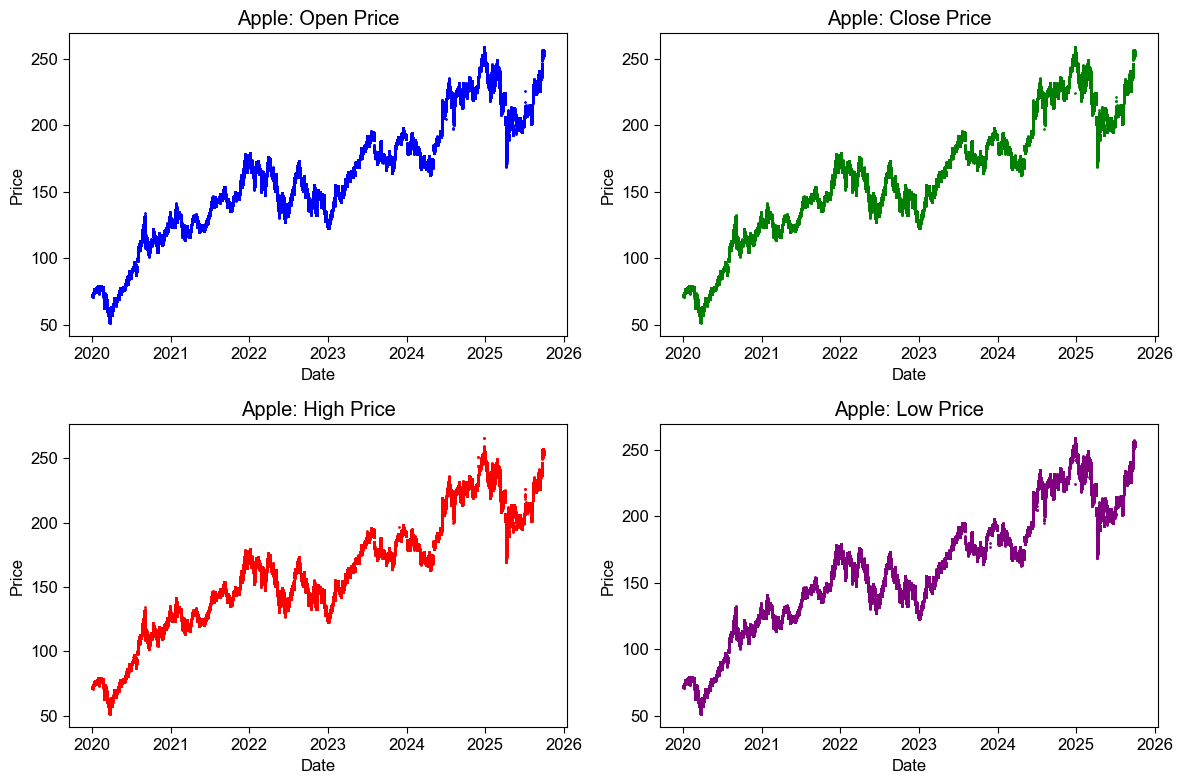

In [18]:
aapl_df['timestamp'] = pd.to_datetime(aapl_df['timestamp'])

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

columns = ['open', 'close', 'high', 'low']
titles = ["Apple: Open Price", "Apple: Close Price", "Apple: High Price", "Apple: Low Price"]
colors = ['blue', 'green', 'red', 'purple']

for ax, col, title, color in zip(axs.flat, columns, titles, colors):
    ax.scatter(aapl_df['timestamp'], aapl_df[col], s=1, color=color)
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")

plt.tight_layout()
plt.show()

### Eli Lilly Plots

Notice that the stock price was increasing steadily until March 2023 when the price increased dramatically. Since June 2024, the LLY stock price has been on a general decreasing trend

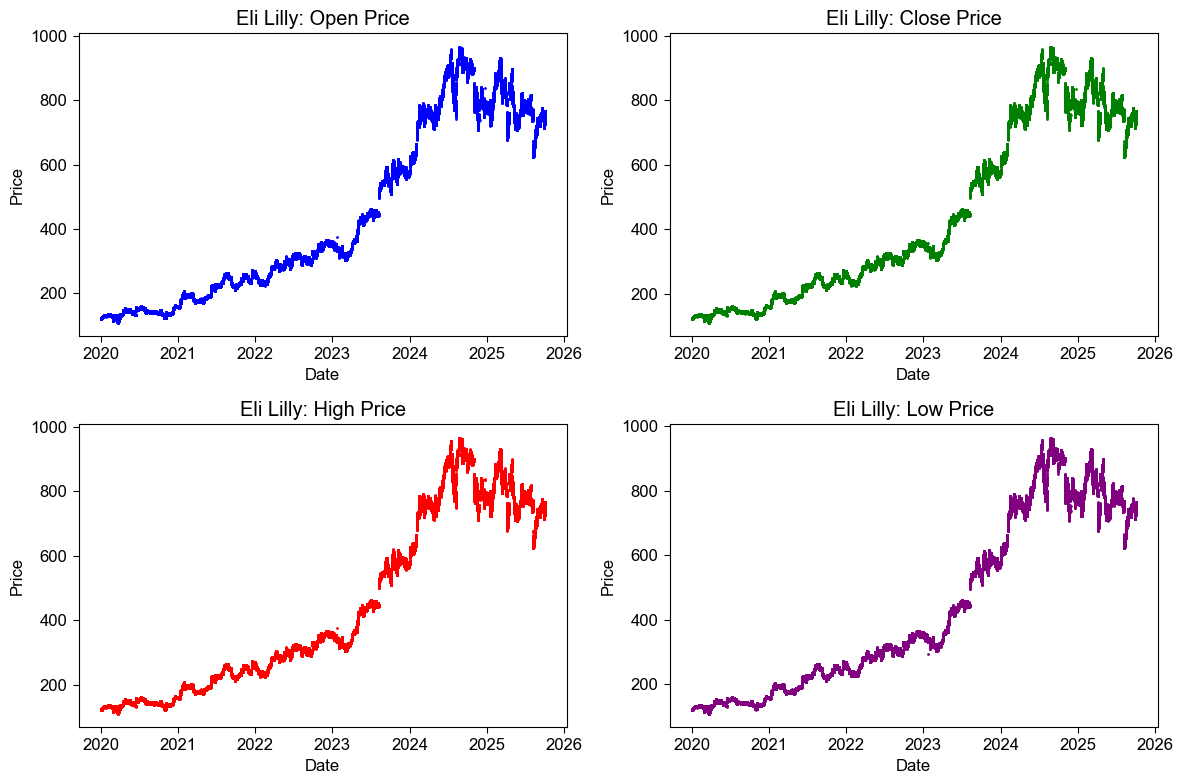

In [24]:
aapl_df['timestamp'] = pd.to_datetime(aapl_df['timestamp'])

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

columns = ['open', 'close', 'high', 'low']
titles = ["Eli Lilly: Open Price", "Eli Lilly: Close Price", "Eli Lilly: High Price", "Eli Lilly: Low Price"]
colors = ['blue', 'green', 'red', 'purple']

for ax, col, title, color in zip(axs.flat, columns, titles, colors):
    ax.scatter(lly_df['timestamp'], lly_df[col], s=1, color=color)
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")

plt.tight_layout()
plt.show()

### Brookfield Plots

Notice that the Brookfield stock price shot up dramatically startin in March 2020 through the end of the year. Since then, there have been many flucations, but a general decrease in stock price. Since the start of 2025, the BEP stock prices has been mostly increasing.

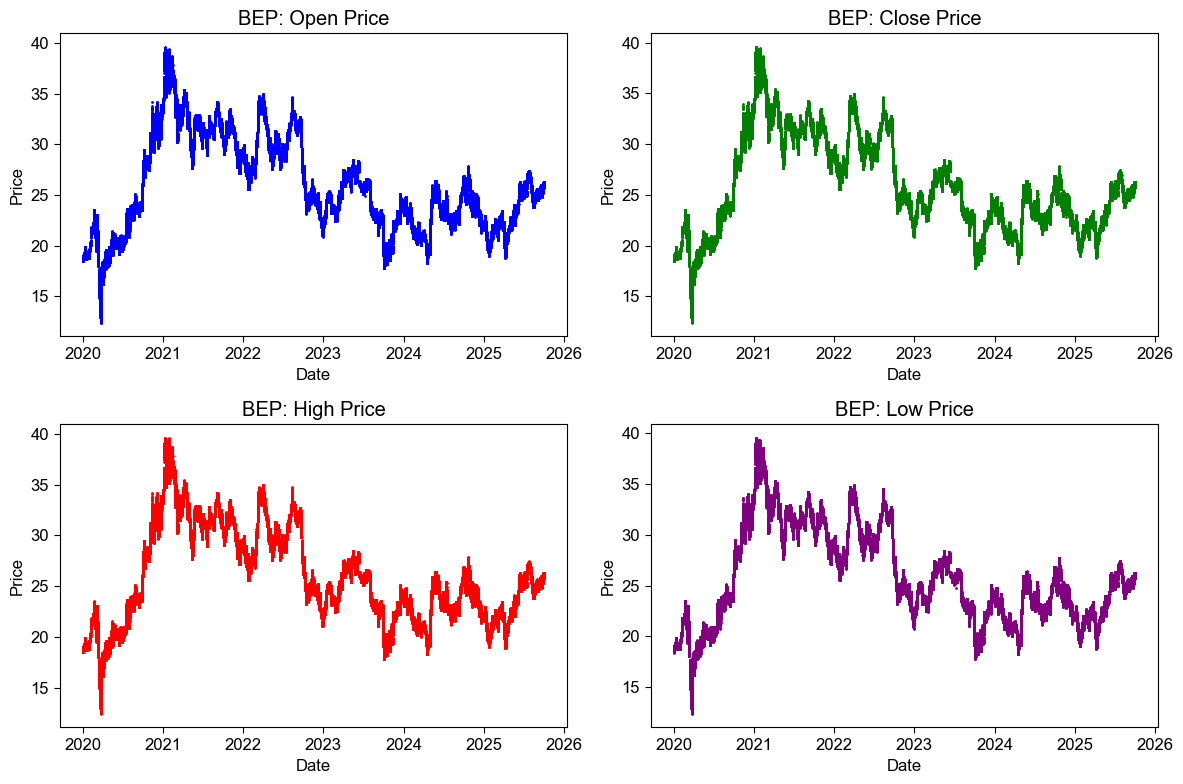

In [25]:
aapl_df['timestamp'] = pd.to_datetime(aapl_df['timestamp'])

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

columns = ['open', 'close', 'high', 'low']
titles = ["BEP: Open Price", "BEP: Close Price", "BEP: High Price", "BEP: Low Price"]
colors = ['blue', 'green', 'red', 'purple']

for ax, col, title, color in zip(axs.flat, columns, titles, colors):
    ax.scatter(bep_df['timestamp'], bep_df[col], s=1, color=color)
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")

plt.tight_layout()
plt.show()

We then calculated the log returns for each minute using the formula log_returns = log(1+(close-open)/open).

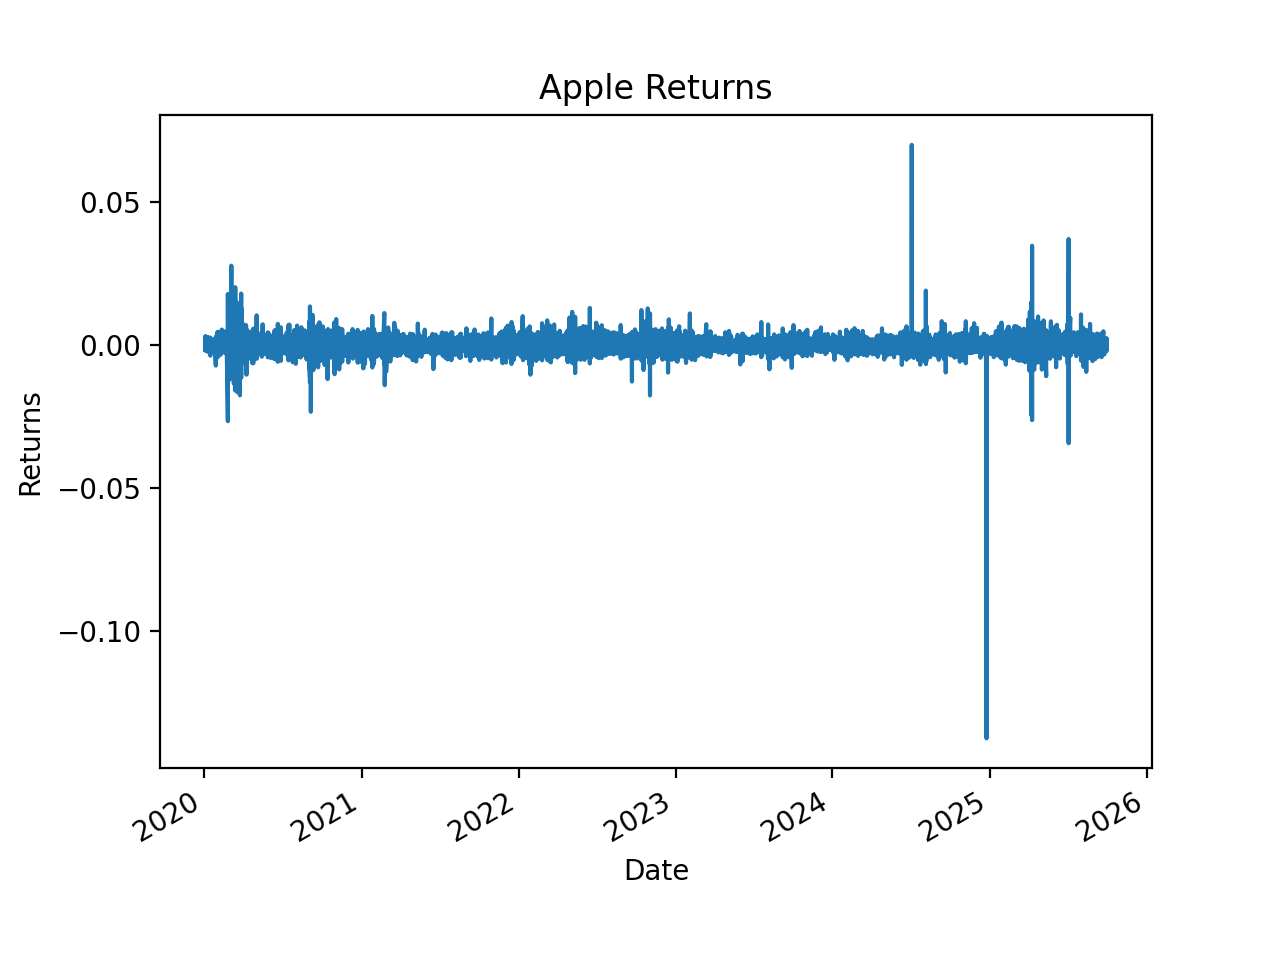

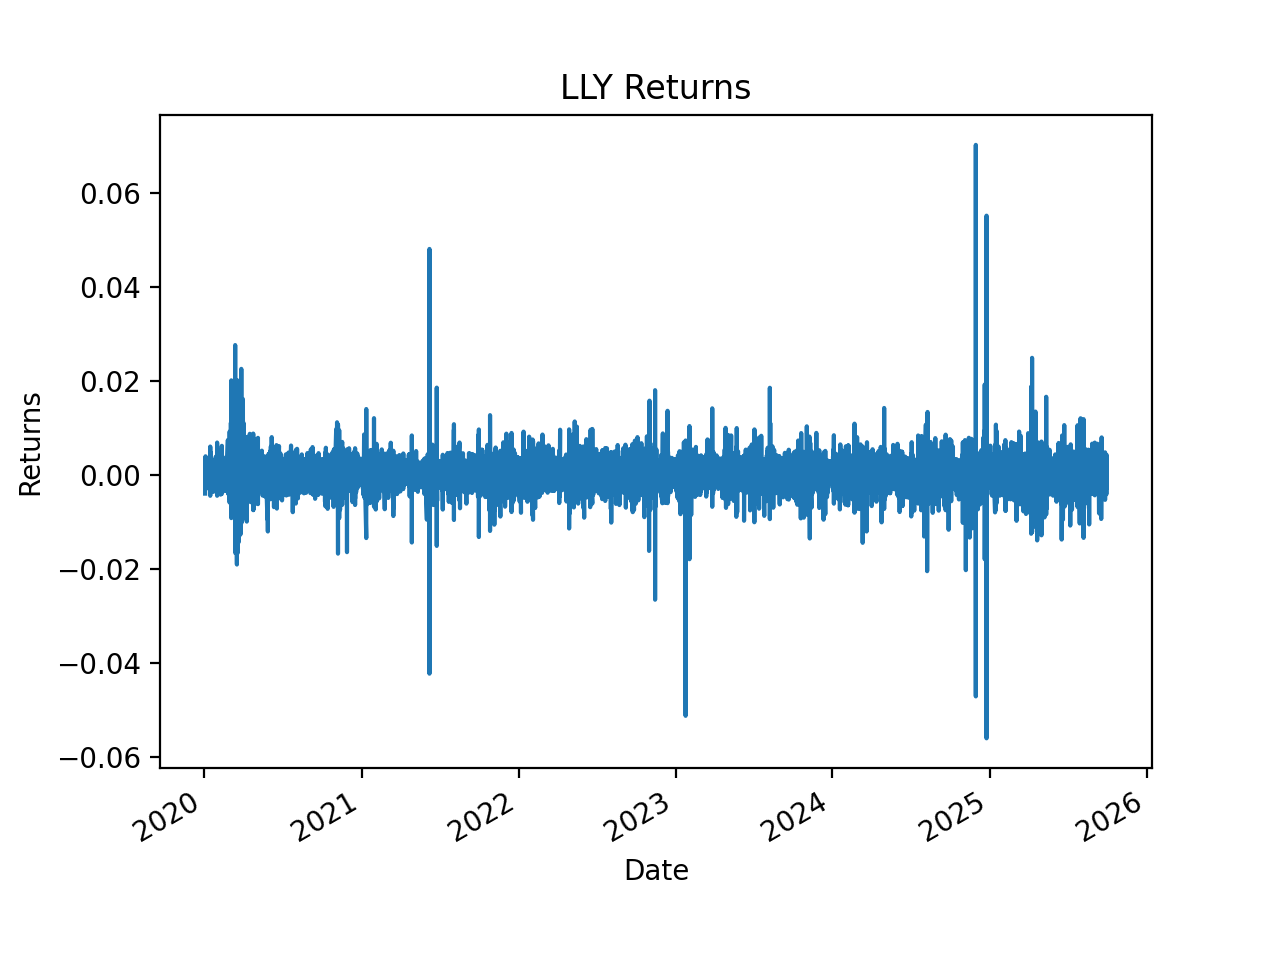

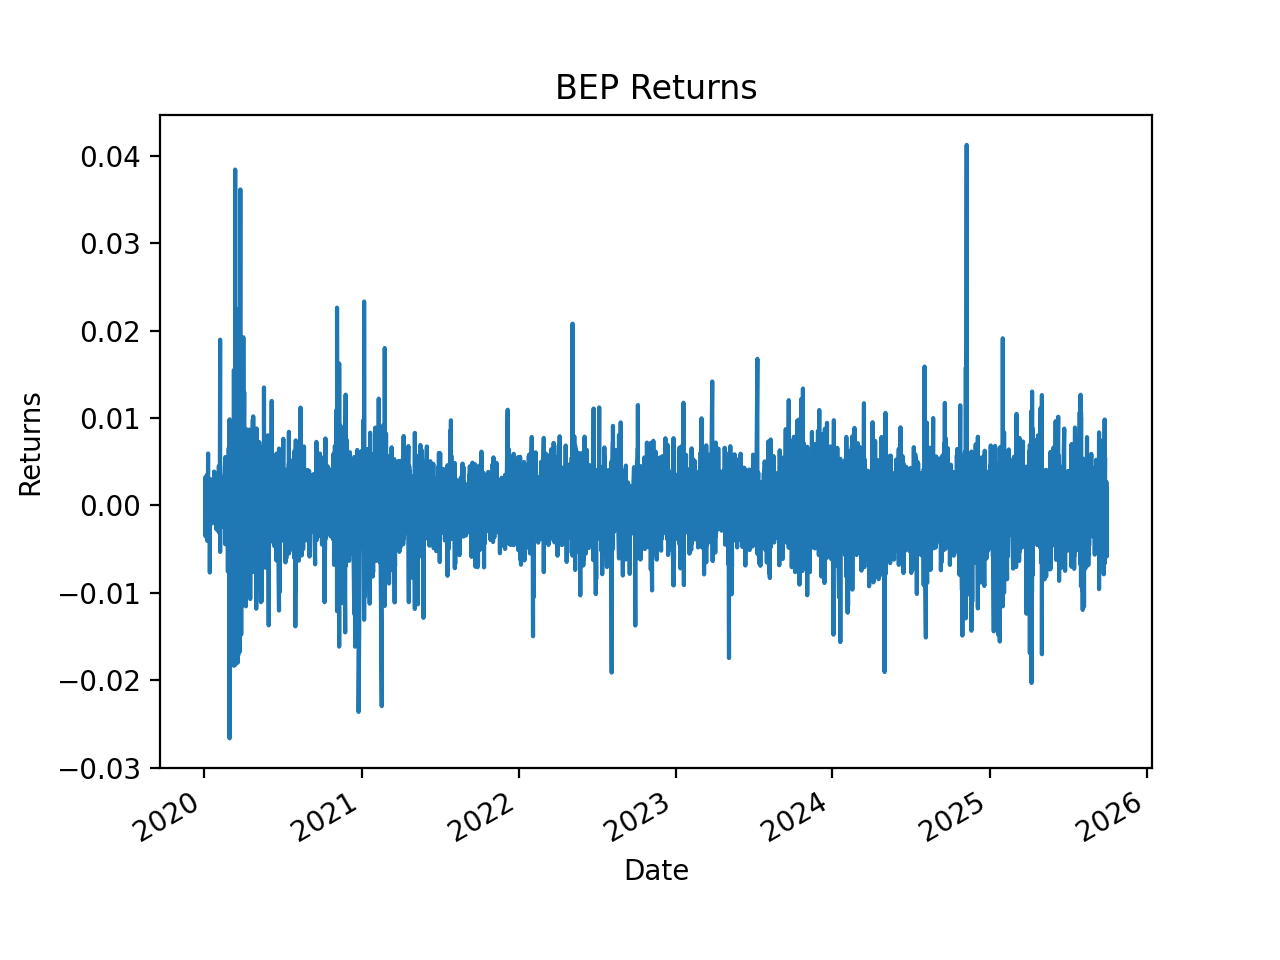

From the log return values, we calculated the daily variance of the returns for each of the stocks and took the square root of the variance to calculate the realized volatility for each stock.\
It was important to derive the daily volatility for each stock because we are trying to predict the volatility for the next day. The data needed to be in the form of daily volatility in order to be interpreted and parsed by the different algorithms.

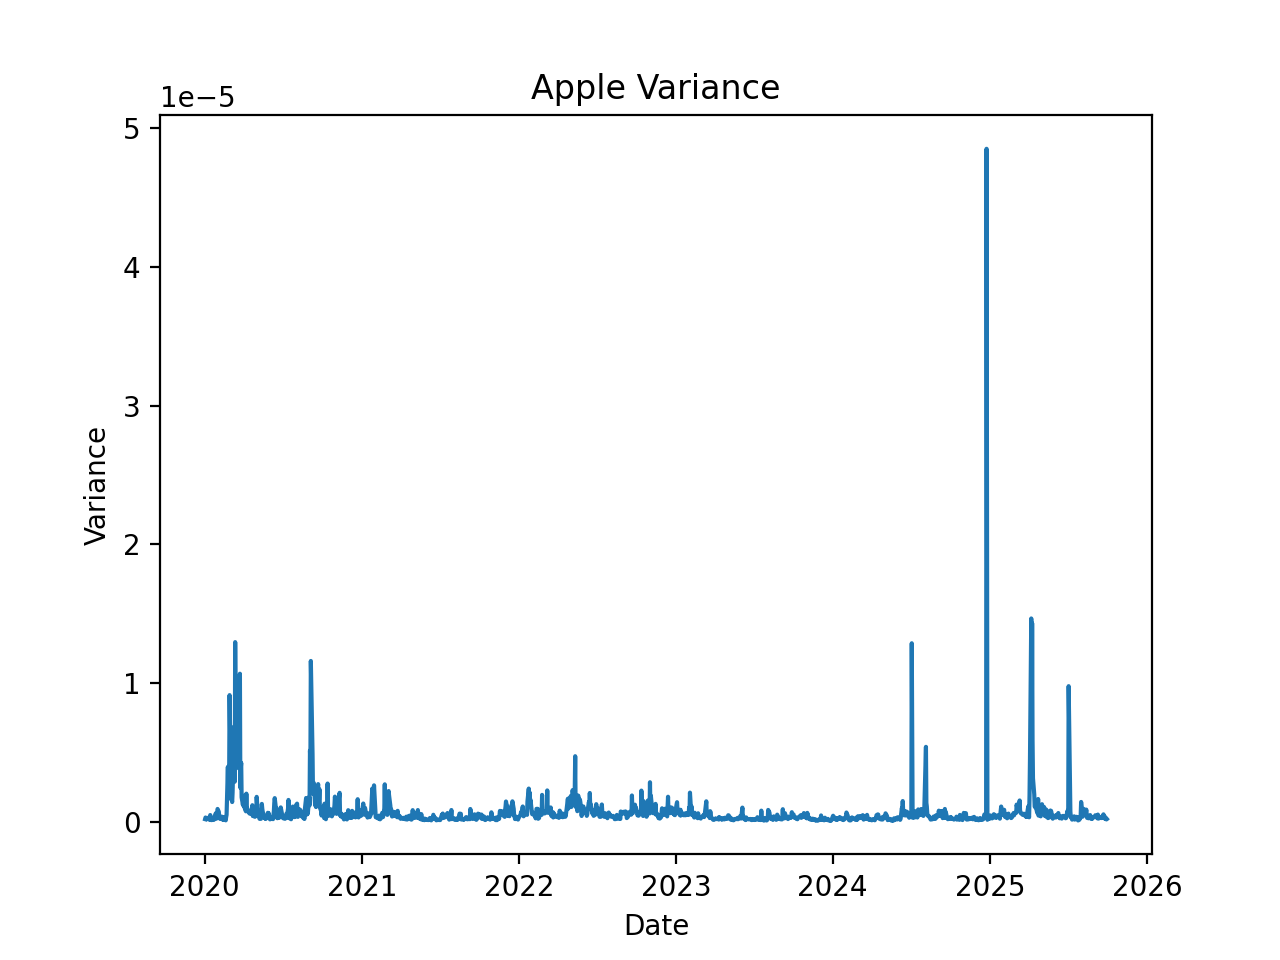

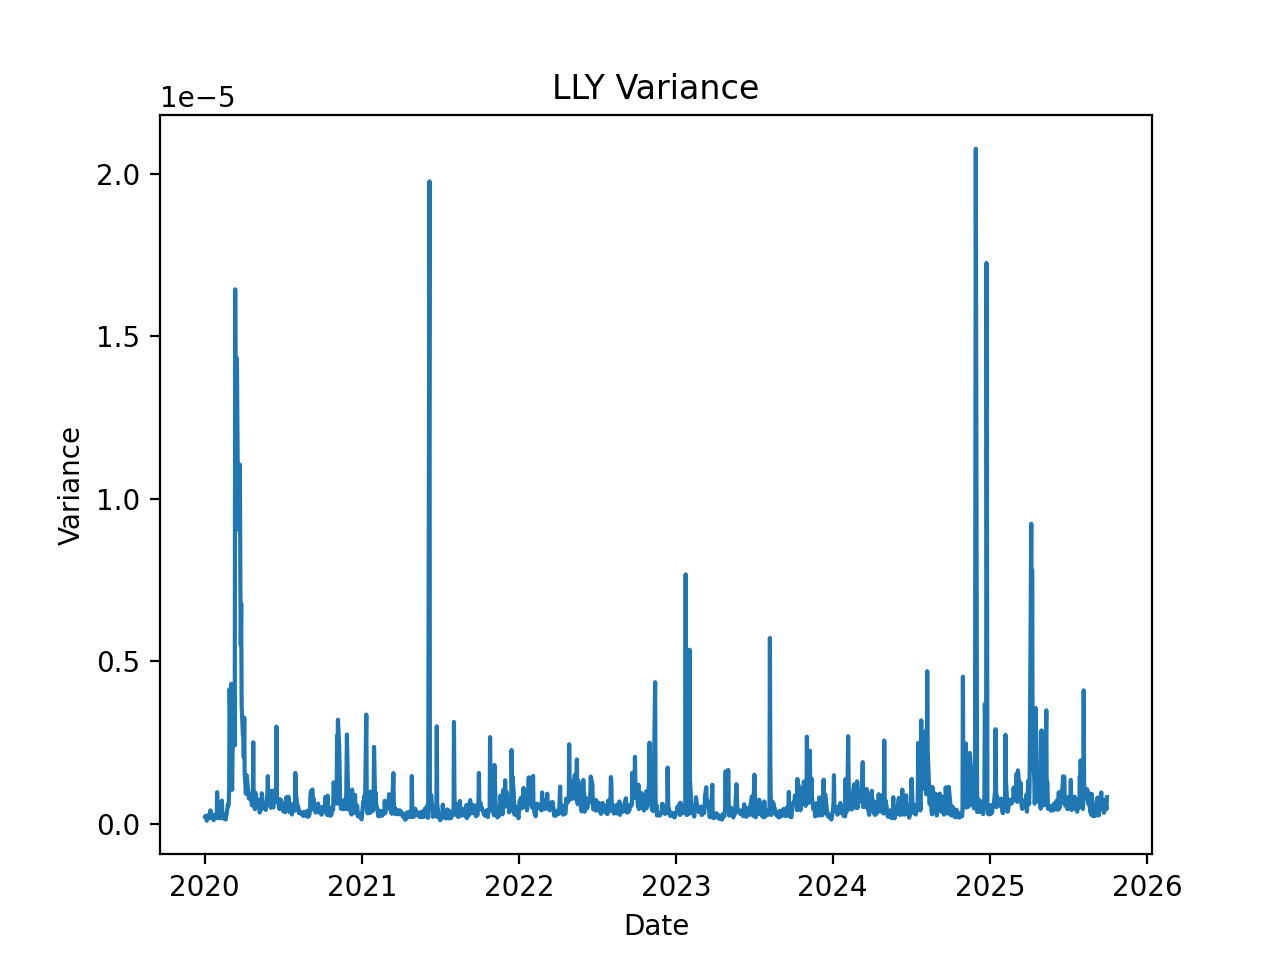

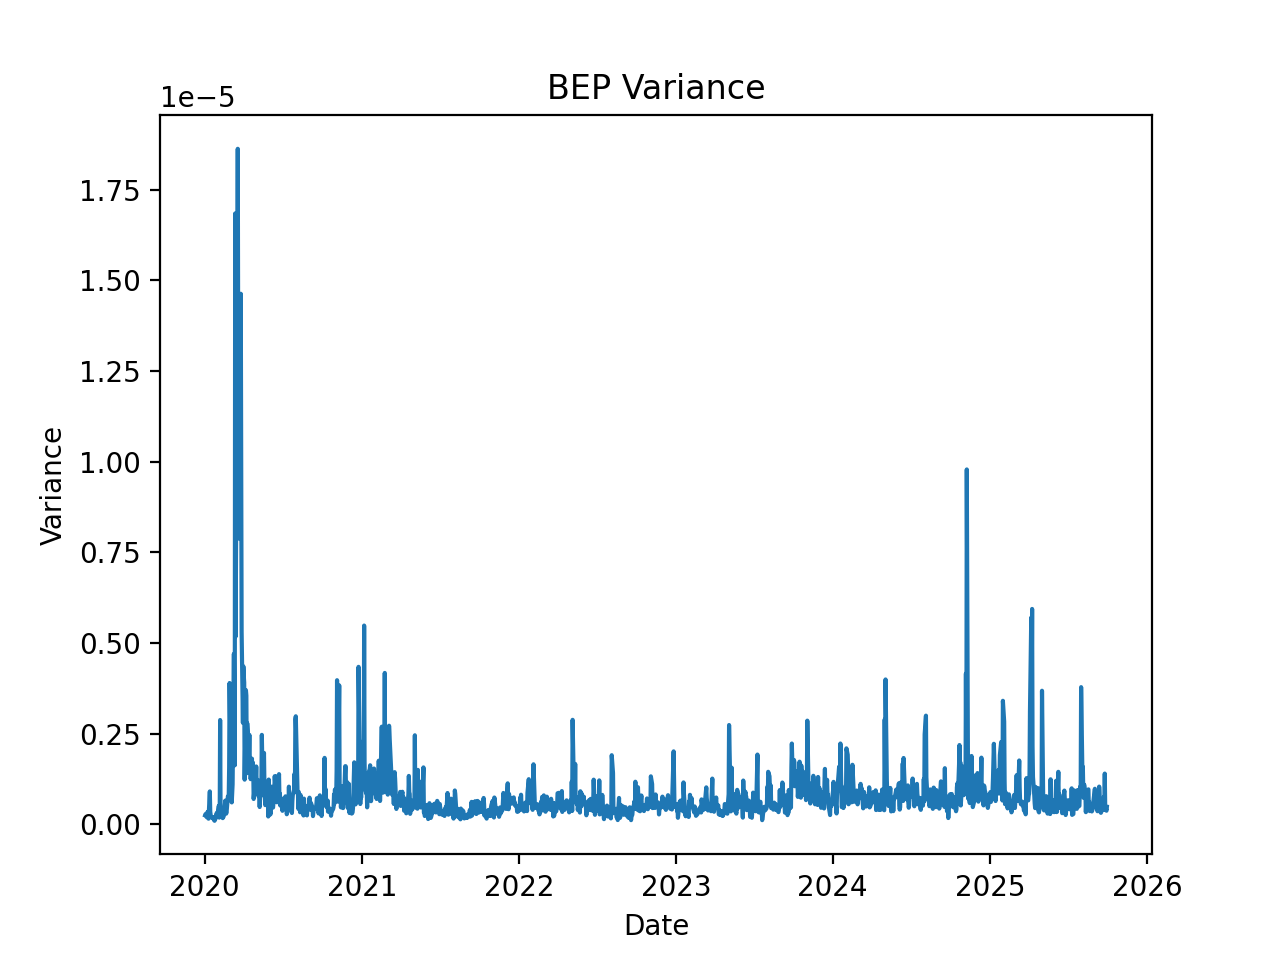

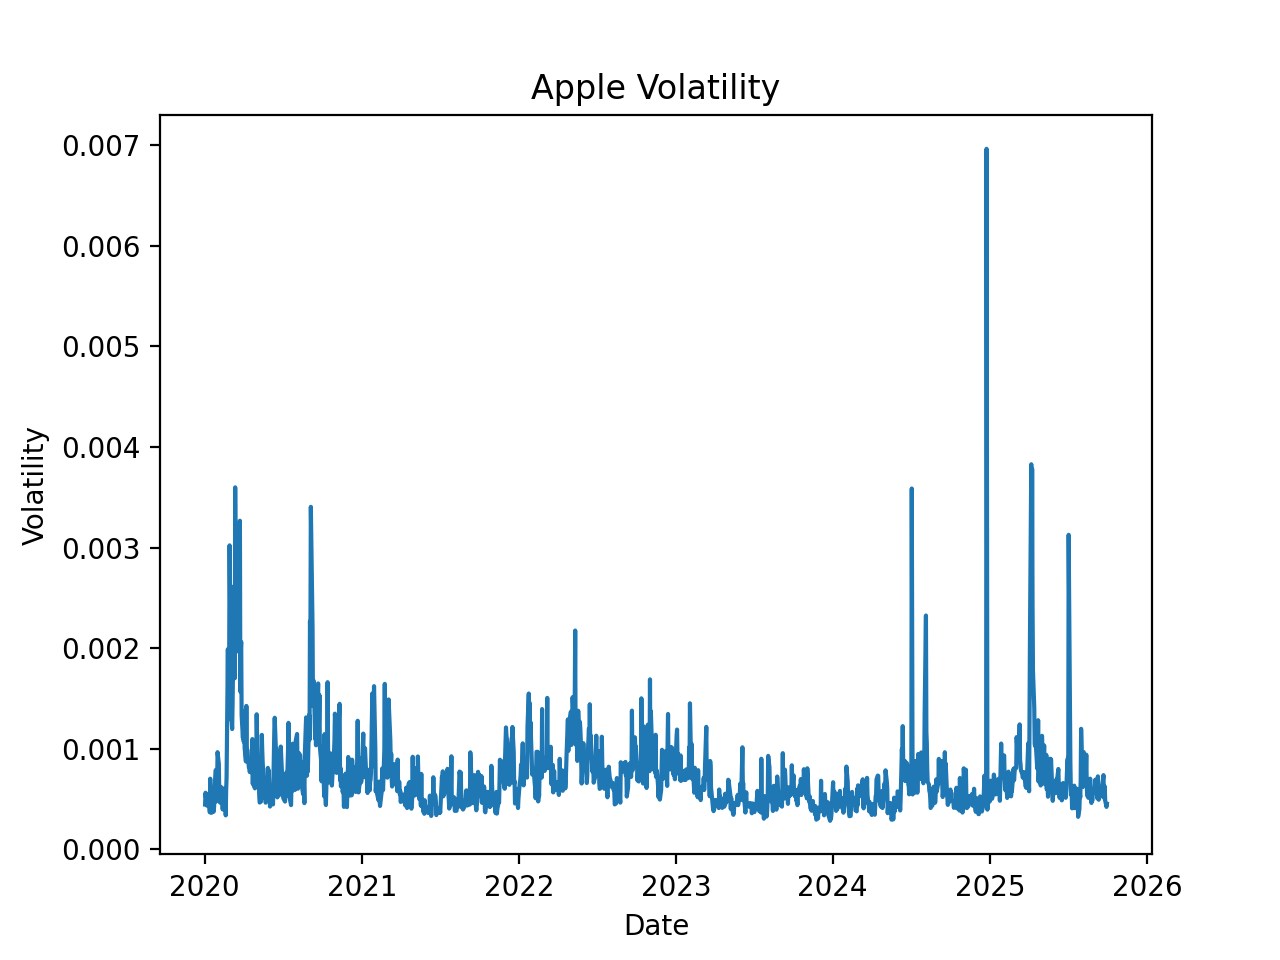

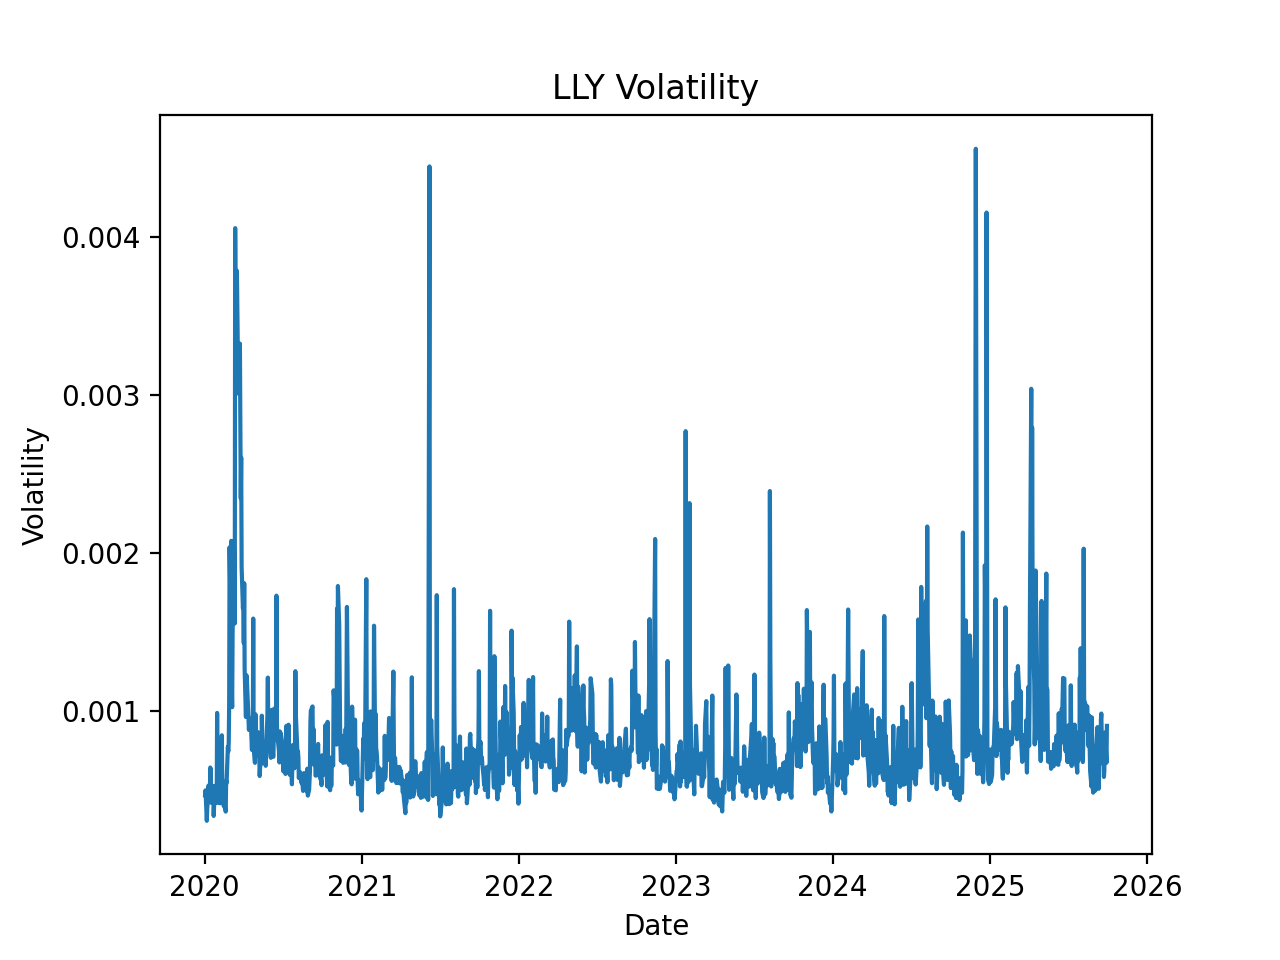

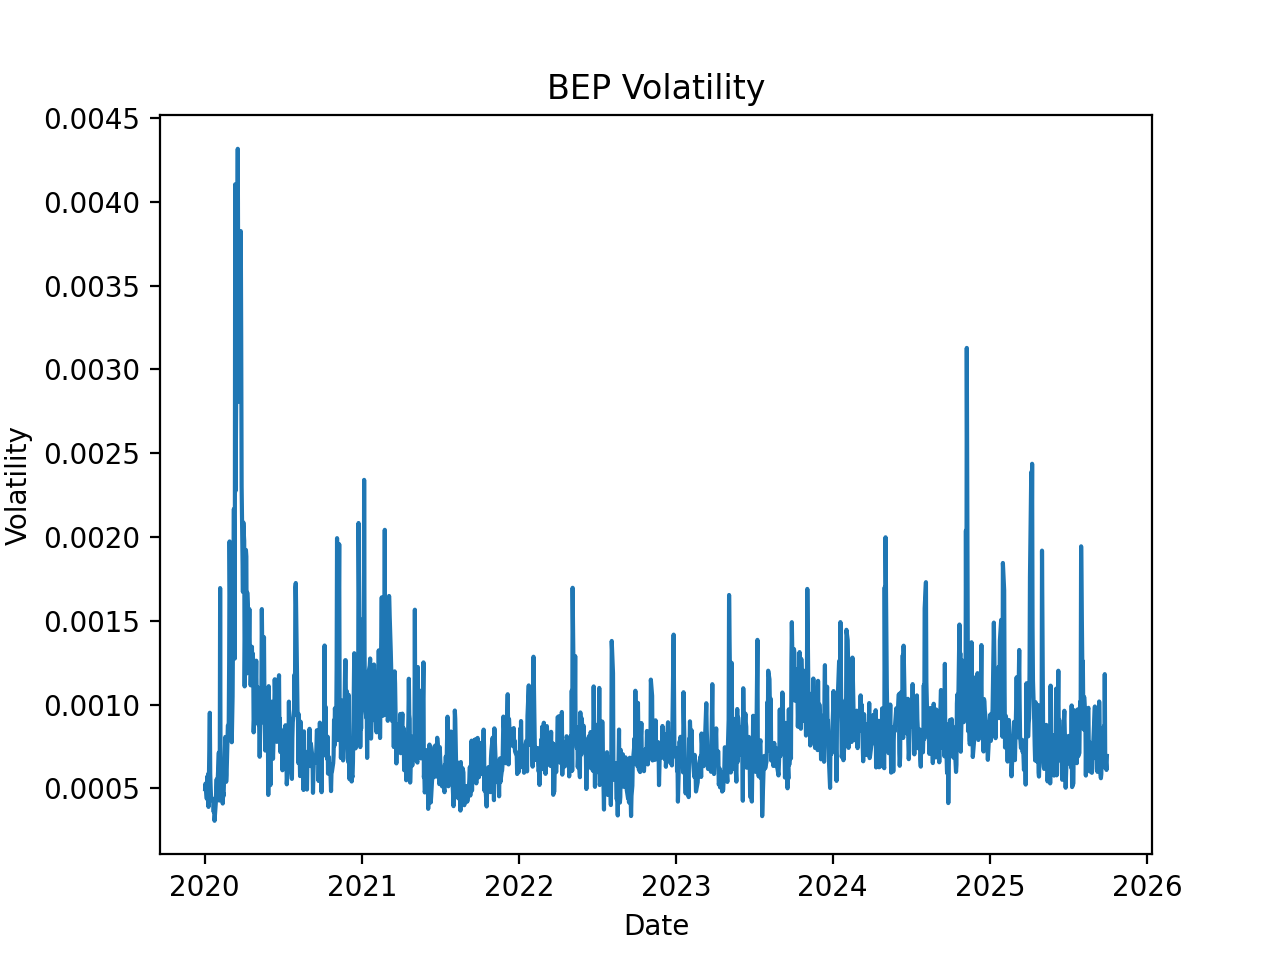

We also looked at the autocorrelation of the daily volatility for the different stocks to see if it is possible to predict future volatility based on historical data. We found that the current volatility shows a clear dependence on values from roughly two weeks prior. This gave us evidence that we can use historical data to predict future volatility.

# Apple Autocorrelation

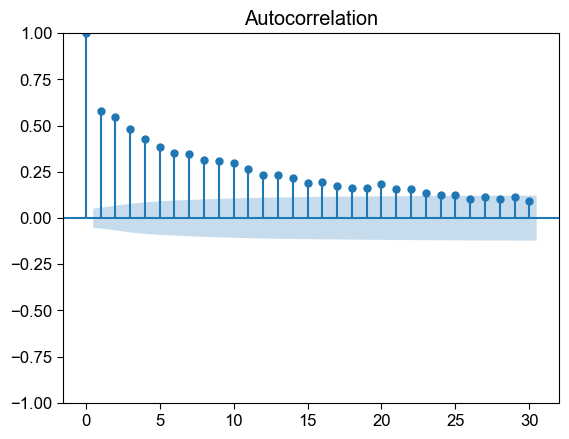

# BEP Autocorrelation

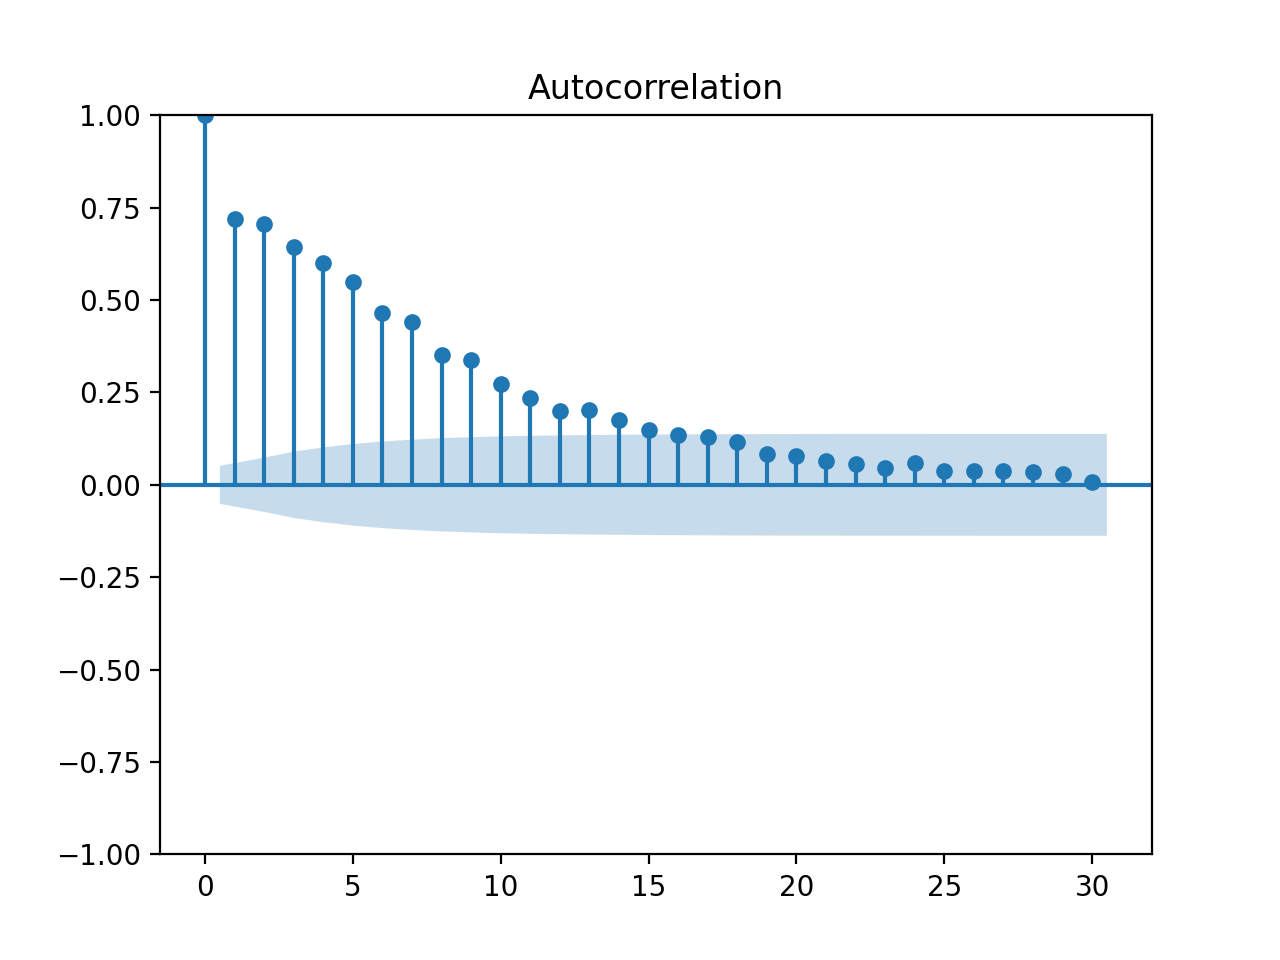

# Eli Lilly Autocorrelation

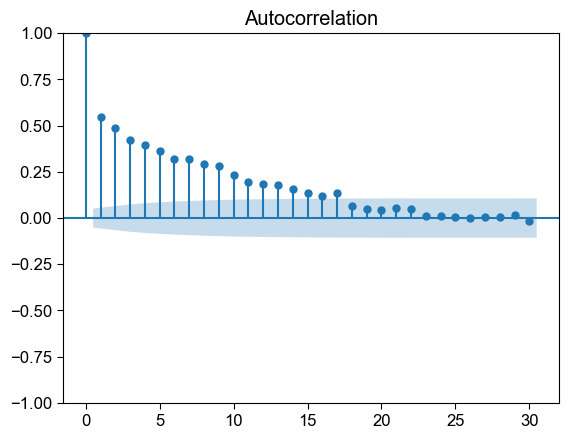

To detect outliers, we used the Seasonal Trend Decomposition using LOESS technique that removes the trend and seasonal components from the data so you are left with the residual component. The method to perform this technique is from the python library from statsmodels.tsa.seasonal import STL. Once we had the residual component for each stock, we found the Q1 and Q3 values of the data, the IQR, and filtered the data so that no datapoint is greater than Q3+1.5*IQR or less than Q1+1.5*IRQ.\
However, we are not certain we want to remove the outliers from the data because we believe that outliers are indicators of volatility. We believe that we can predict some of what the STL method considers to be outliers through a more robust model that includes supplemental information.

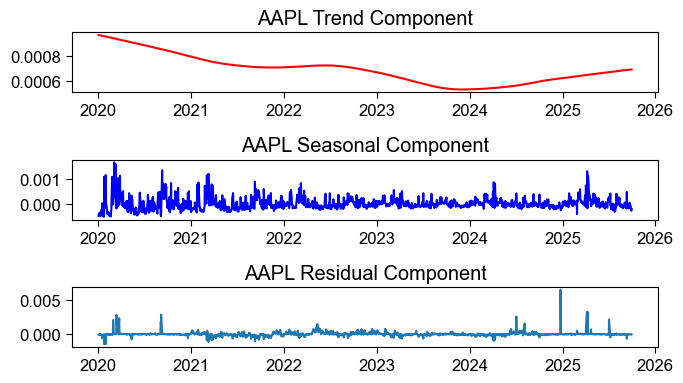

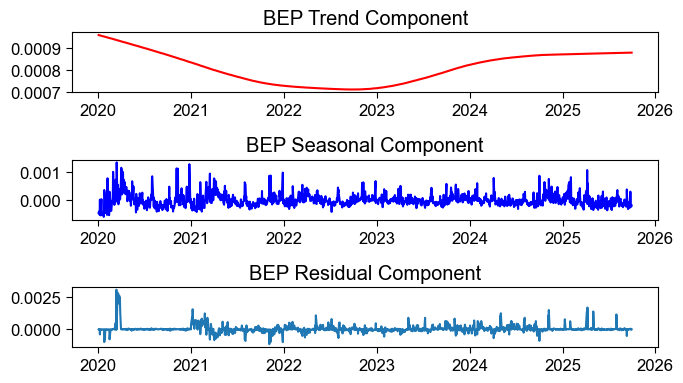

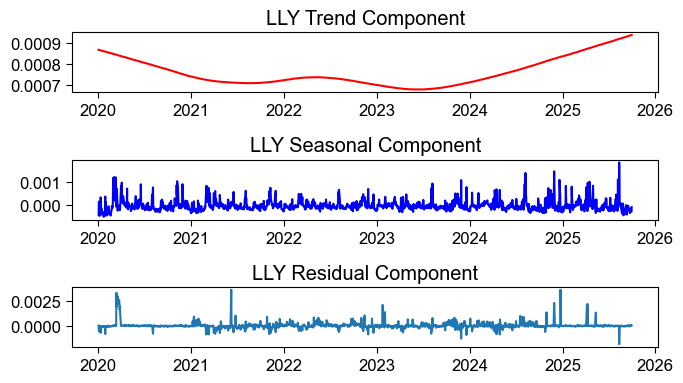

# Model Updates

We are using three types of models – Exponentially Weighted Moving Average (EWMA), Autoregressive Integrated Moving Average (ARIMA), and a Recurrent Neural Network (RNN) – to forecast short-term volatility of our selected stocks. We are treating EWMA and ARIMA as our baseline models, since they are both standard statistical models that are easy to interpret. Meanwhile, we hope that our RNN will form a more robust prediction, despite suffering from the “black-box” of neural networks.

EWMA is a variant of a Moving Average model that weights observations based on their temporal proximity to the prediction time. The model assumes that more recent observations should be weighted more heavily, and thus weights more recent observations more heavily. EWMA models are often used for financial market volatility prediction because heavier weights on more recent observations allow the model to react more quickly to clusters and spikes in the data than a standard Moving Average model can react. After a quick check, we found that an EWMA model with a decay factor of 0.9 best fit our data, as can be seen in the graphs below. We plan to complete a more thorough check using k-fold cross validation to ensure that we have selected the optimal hyperparameter.

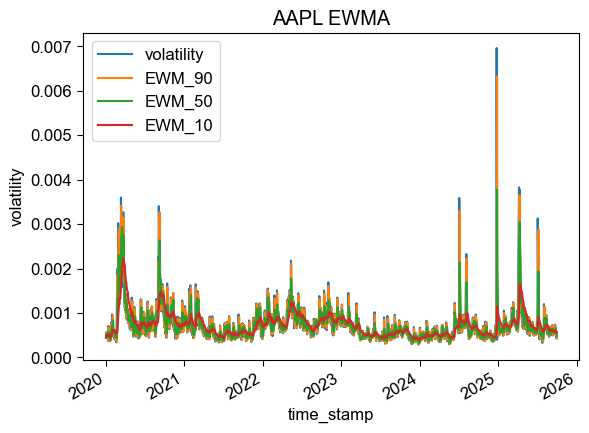

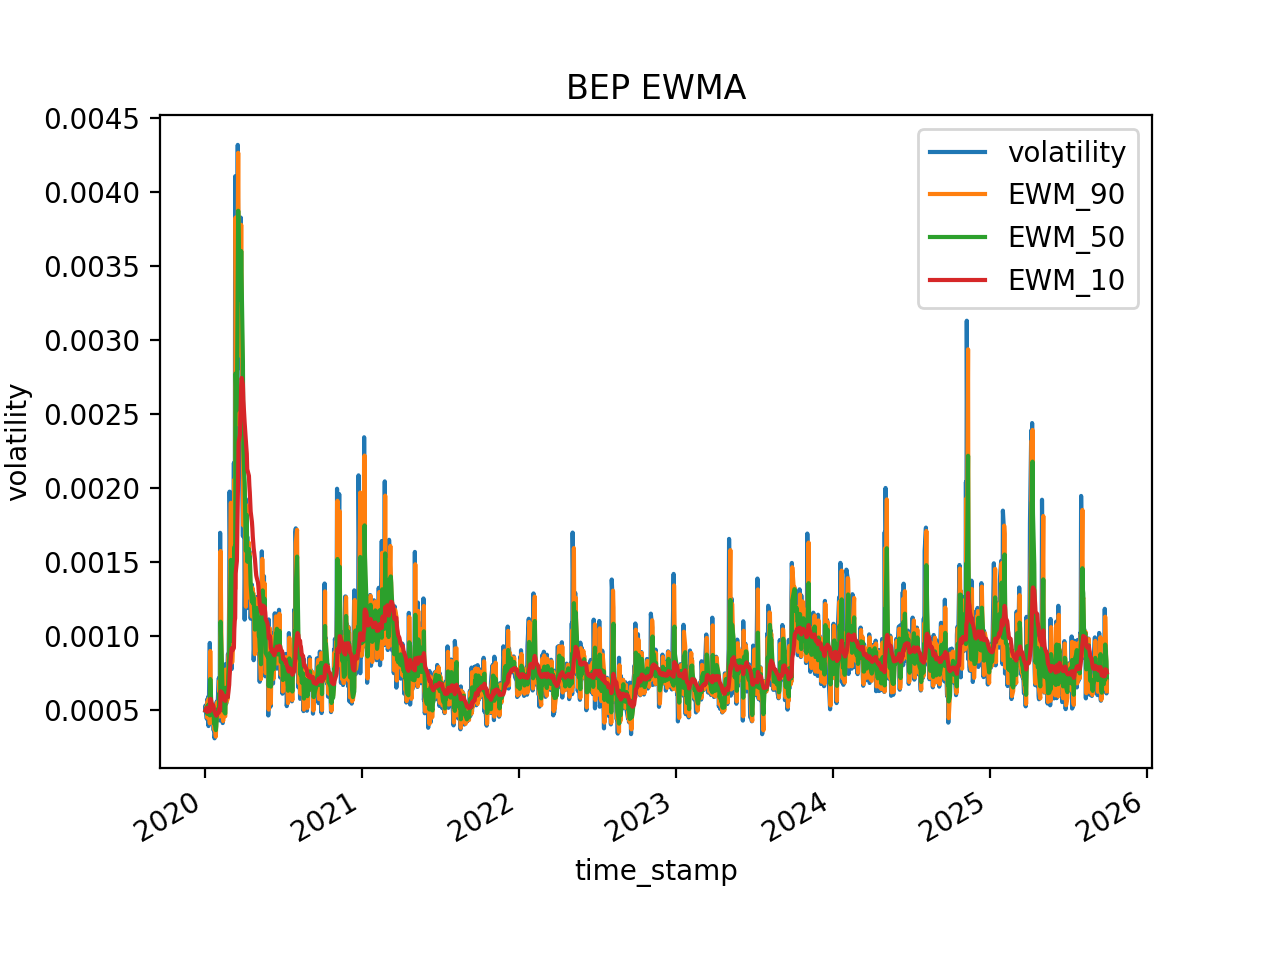

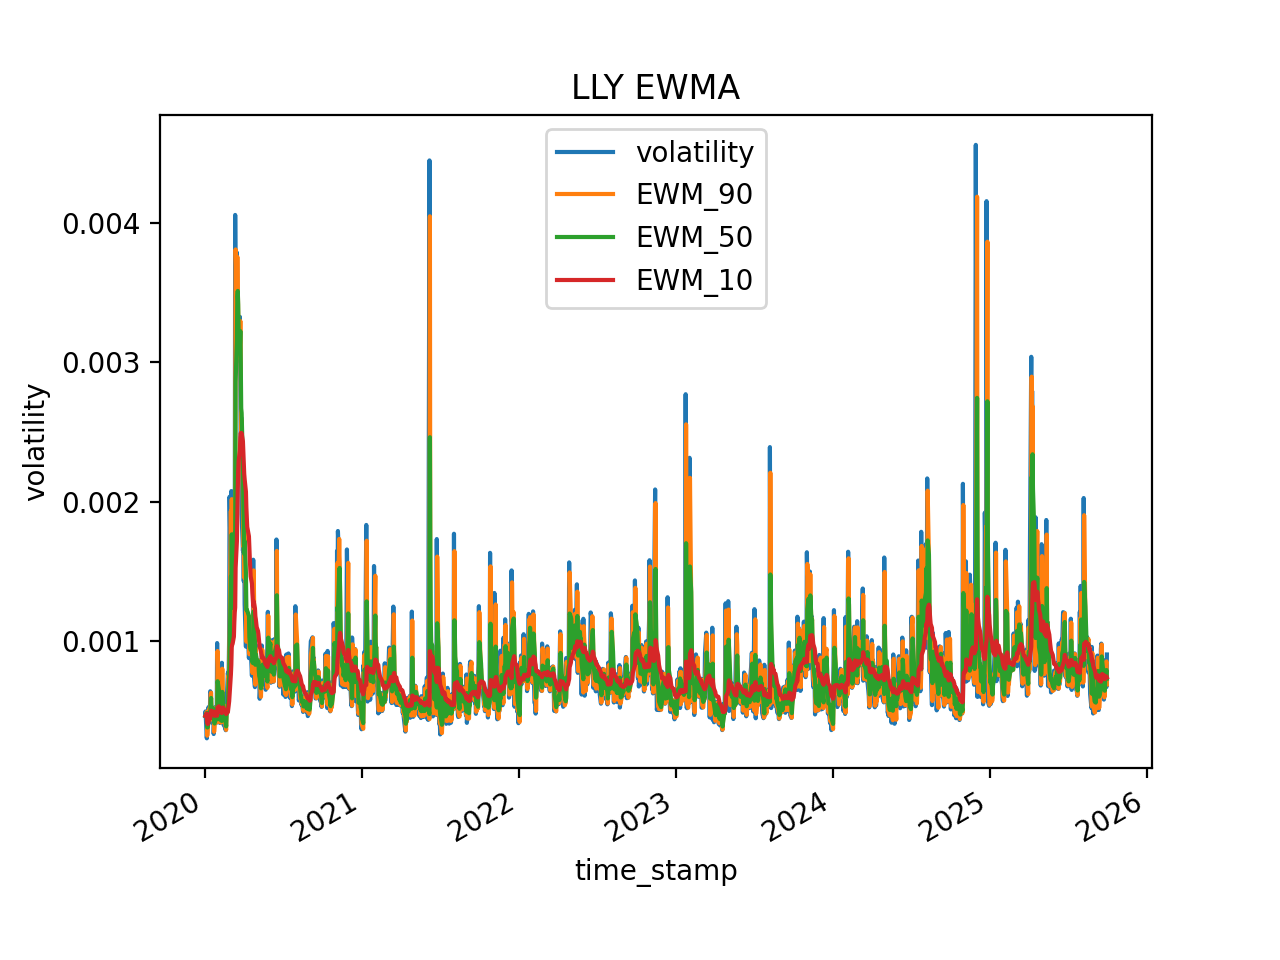

ARIMA is a variant of an Autoregressive Moving Average model that allows for analysis and predictions for non-stationary data. The integration (differencing) removes the underlying trends in the data, allowing for the data to be “assumed” as stationary data. Meanwhile, the Autoregressive part of the model captures the dependence on past observation values. The Moving Average portion of the model addresses the past forecast errors, or how much the model depends on past shocks. Like EWMA, ARIMA models are also commonly used for volatility forecasting since volatility series typically exhibit autocorrelation and mean reversion.


RNNs are a form of neural network that have an internal memory that allows the model to recursively propagate information through time. While EWMA and ARIMA models access the relationship between lagged data in their construction, RNNs create more robust predictions by capturing temporal context. We think that an RNN will be beneficial for financial market volatility forecasting since it will address the temporal structure of our stock price data and be able to incorporate new features, like market holidays and earnings report timing, to adapt to the non-stationary, non-linear nature of the stock volatility.


Our data and modelling workflow can be thought of as a Machine Learning Morphism, a mapping from the raw market data to the volatility forecasts using data processing and modelling to learn a prediction function. The first phase of our MLM pipeline was downloading and cleaning our data, as described in the previous step. The processed data forms the input for our morphism. The next phase of our MLM is model training which has three contributing sub-components, each corresponding to a modelling technique. The EWMA sub-component captures the deterministic relationships in the data. The ARIMA sub-component adds mean-related dynamics and lag correlation to the mapping. Finally, the RNN sub-component contributes historic, temporal context to our learning problem. Our MLM is constrained by the necessity of meaningful prediction values. Our predictions need to be stable and financially valid. For example, a negative stock price and, thus, a negative volatility forecast, is meaningless since financial markets do not support negative pricing. Also, our MLM can only use past data to make predictions, which, on a theory level, behaves as a constraint. Further, each sub-component has its own mathematical constraints, like how the weights in an EWMA model must sum to equal one. Through this perspective, our project workflow is an MLM.

Speficially diving into one of the models, our neural network that we plan to build, can be mapped as a Machine Learning Morphism. Its input space consists of volatility, lagged moving averages, earnings history, quarterly earnings release date, and calendar dates that have large effects on stock prices. The processing consists of the data processing of the minutely returns as mentioned above, as well as encoding the calendar dates into categories and how far a stock is from its quarterly earning release. Its output space will be all real numbers greater than or equal to 0, the predicted volatility for the next day. For the parametric morphism (Fp), we will be using a Recurrent Neural Network. It is a supervised learning paradigm since we have historical volatility that will be used as labels. The neural network is being used to perform regression and we will use the mean squared error as the loss function. We will utilize Ridge Regression as the regularization to penalize the model for overreacting to recent spikes in volatility. The predicted volatility can not be a negative number, so there will be a constraint in the model that the output has to be greater than or equal to zero.


# Next Steps

Our immediate next steps are to continue model building and tuning. For our EWMA model, we are planning to perform cross-validation to optimize the decay factor hyperparameter. We have not yet created our ARIMA or RNN models, but we plan to build and tune those in the next week. Before developing the RNN, we will collect some supplemental data (NYSE holidays, earnings reports, etc.) to add as model inputs. This will be done in the next week as well. Once all of our models are fit, we will also experiment with stacking or mixing the models to create a more robust prediction. Our long-term next steps also include building out an LLM that can use narrative intelligence to inform users on whether a current short-term investment in a specific stock is recommended.
